# Analysis of Sweep Results for Main Paper

### Imports:

In [1]:
import sys
sys.path.append('../')
from analysis_utils import rerun_trials, load_checkpoints, batched_cov_and_pcs, import_checkpoint
import numpy as np
import torch
from torch import nn
import neurogym as ngym
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 15
BIGGEST_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(f'<h4>{string}</h4>'))

def printbigmd(string):
    display(Markdown(f'<h2><center style="color:red">{string}</center></h2>'))

In [2]:
def plot_stacked(series, space = 4, ytick = None):
    # series should be shape [Tsteps, Count].
    # Will stack these vertically in a plot. 
    spacing = np.cumsum(space*series.std(axis=0))
    spacing = np.pad(spacing, (1, 0))[:-1] # Put a zero at start.
    middles = spacing + series.mean(axis=0)
    stacked = series + spacing[None, :]

    plt.plot(stacked)
    if ytick is not None:
        plt.yticks(ticks = middles, labels = ytick)
    plt.xlabel('Time, t')

def effective_rank(A, thresh):
    S = np.linalg.svd(A, full_matrices=False)[1]
    variances = S**2
    total_variance = np.sum(variances)
    
    # Find the smallest k such that cumsum_variances[k] >= threshold * total_variance
    return np.searchsorted(np.cumsum(variances), thresh * total_variance) + 1

# A list of tasks I got decent accuracy on:
tasks_decent_acc = 'PerceptualDecisionMaking-v0 OneTwoThreeGo-v0 MultiSensoryIntegration-v0 MotorTiming-v0 IntervalDiscrimination-v0 GoNogo-v0 DelayPairedAssociation-v0 DelayComparison-v0 ContextDecisionMaking-v0'
tasks_decent_acc = tasks_decent_acc.split() # str -> list of str.

# Second run I did:
tasks_decent_acc = 'MotorTiming-v0 AntiReach-v0 DelayComparison-v0 ProbabilisticReasoning-v0 MultiSensoryIntegration-v0 PerceptualDecisionMaking-v0 PerceptualDecisionMakingDelayResponse-v0'
tasks_decent_acc = tasks_decent_acc.split() # str -> list of str.


### Set the root directory of data to analyze. <strong>User should customize:</strong>

In [3]:
neurogym_root = '/home/ws3/Desktop/james/neurogym/examples/'
task = 'DelayMatchSample-v0'
root = neurogym_root + 'default_init_no_stopping_' + task + '/'
printbigmd(f'Data root file: {root}')

<h2><center style="color:red">Data root file: /home/ws3/Desktop/james/neurogym/examples/default_init_no_stopping_DelayMatchSample-v0/</center></h2>

In [6]:
checkpoints, GD_iteration = load_checkpoints(root)
checkpoints, GD_iteration = checkpoints[::5], GD_iteration[::5] # Subset
GD_iteration = np.array(GD_iteration)
printbigmd(f'{len(checkpoints)} Checkpoints, over {GD_iteration[-1]} GD iterations')

<h2><center style="color:red">40 Checkpoints, over 9750 GD iterations</center></h2>

In [7]:
def set_x_axis_iterations():
    curtick = plt.xticks()[0]
    xlm = plt.xlim()
    labels = curtick * GD_iteration[-1] / (len(checkpoints) - 1) 
    plt.xticks(curtick, labels)
    plt.xlim(xlm[0], xlm[1])

## Analysis Begins...

#### Define the task inputs and targets. These will be consistently used for all reruns:

In [8]:
def load_task(task, ntrials = 2560):
    kwargs = {'dt': 100}
    seq_len = 100
    dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=ntrials, seq_len=seq_len)

    inputs, labels = dataset()
    inputs, labels = inputs.swapaxes(0,1), labels.swapaxes(0,1)
    targets = nn.functional.one_hot(torch.from_numpy(labels)).numpy()
    return inputs, labels, targets
inputs, labels, targets = load_task(task, ntrials = 1000)
printmd(f'Input size [B, T, n_in]: {inputs.shape}, Target size [B, T, n_out]: {targets.shape}')

/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/home/ws3/anaconda3/env

<h4>Input size [B, T, n_in]: (1000, 100, 3), Target size [B, T, n_out]: (1000, 100, 3)</h4>

#### Rerun all checkpoint models on these data:

In [9]:
zs_all, adjs_all, outs_all, losses_all, grads_all = rerun_trials(inputs, targets, checkpoints, compute_adj = True, device='cpu')
printmd(f'zs shape is [checkpoints, trials, timesteps, n_hidden]: {zs_all.shape}')

Re-evaluating on the Same Data.


/home/ws3/Desktop/james/neurogym/examples/default_init_no_stopping_DelayMatchSample-v0/checkpoints/checkpoint_9750.pt: 100%|██████████| 40/40 [00:10<00:00,  3.87it/s]


<h4>zs shape is [checkpoints, trials, timesteps, n_hidden]: (40, 1000, 100, 200)</h4>

### Analysis of Model Performance:

/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/matplotlib_inline/config.py:59: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


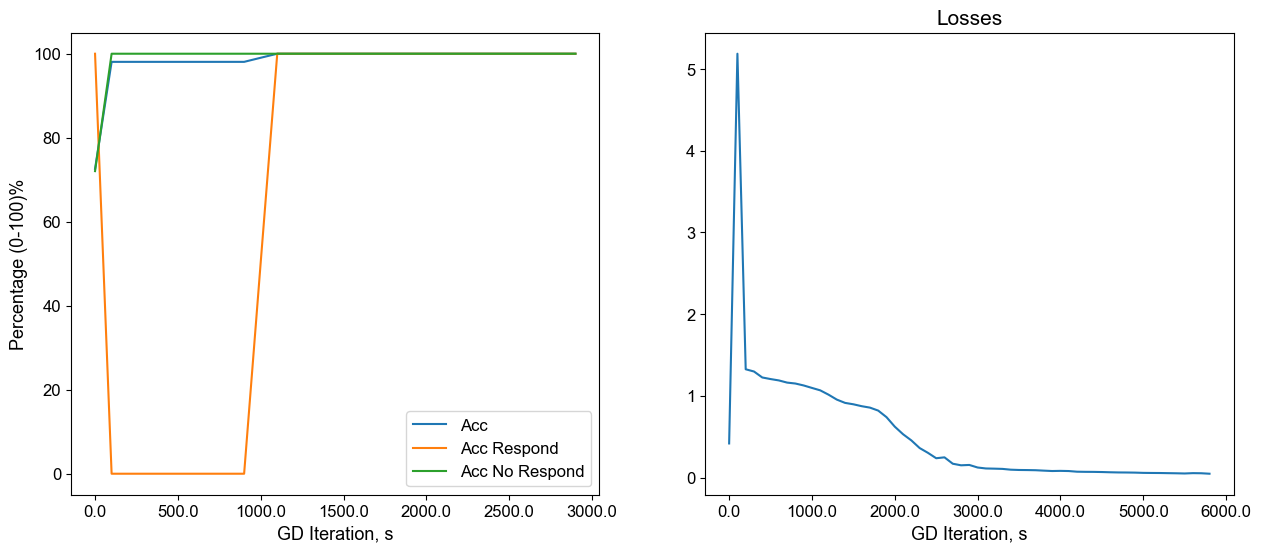

In [10]:
def acc_measures(outs, labels):
    out_labels = np.argmax(outs, axis = -1)
    base_acc = (out_labels == labels).mean() # Responses overall.
    acc_response = (out_labels == labels)[labels != 0].mean() # Responses when the model should be responding.
    acc_no_respond = (out_labels == labels)[labels == 0].mean() # Responses when model shouldn't respond at all.
    return base_acc, acc_response, acc_no_respond

accs = []
for out in outs_all:
    accs.append(list(acc_measures(out, labels)))
accs = np.array(accs)

plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
# plt.yscale('log')
plt.plot(accs*100)
# plt.ylim(70, 110)

plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
set_x_axis_iterations()
plt.legend(['Acc', 'Acc Respond', 'Acc No Respond'])
plt.ylabel('Percentage (0-100)%')
plt.xlabel('GD Iteration, s')

plt.subplot(1,2,2)
plt.plot(torch.load(checkpoints[-1], weights_only=True)['losses'])
plt.xlabel('Loss (mse)')
plt.title('Losses')
plt.xlabel('GD Iteration, s')
set_x_axis_iterations()
plt.show()

Shape of inputs, targets, labels, hidden:  (1000, 100, 4) (1000, 100, 2) (1000, 100) (30, 1000, 100, 128)


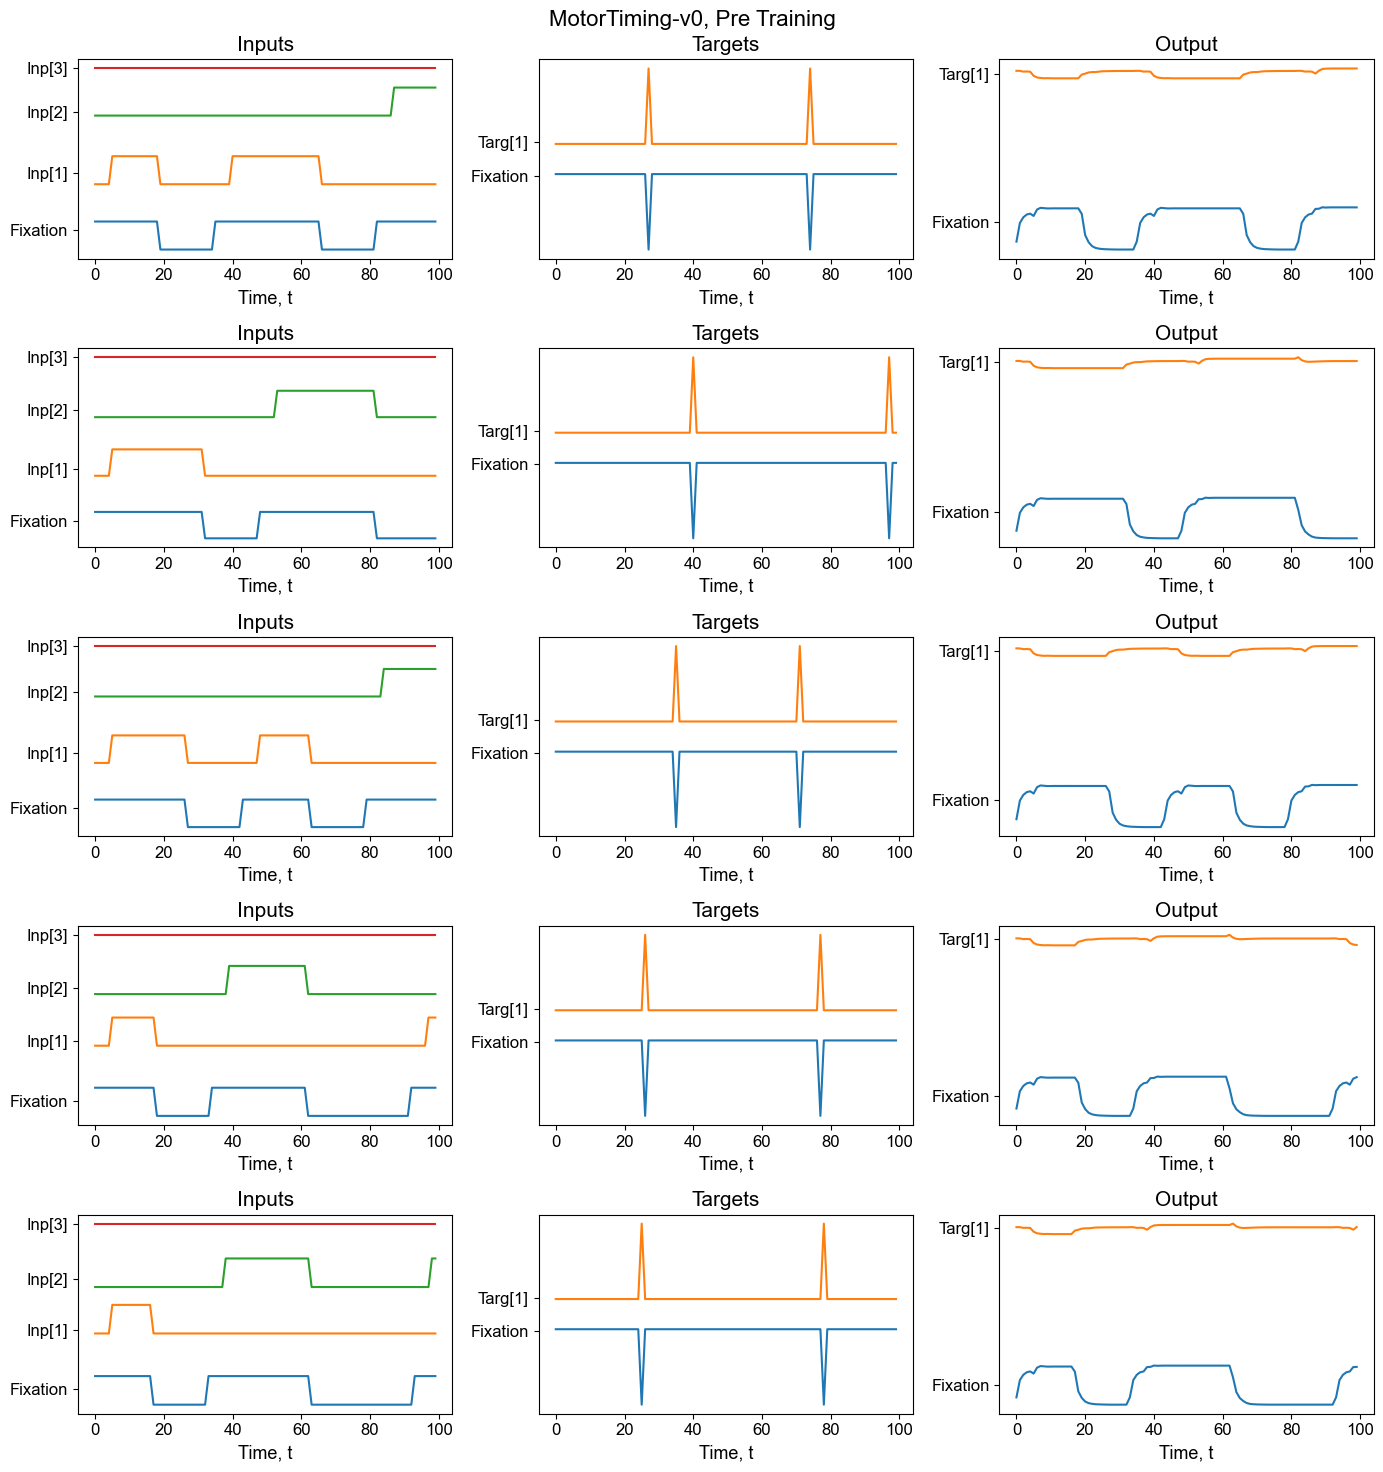

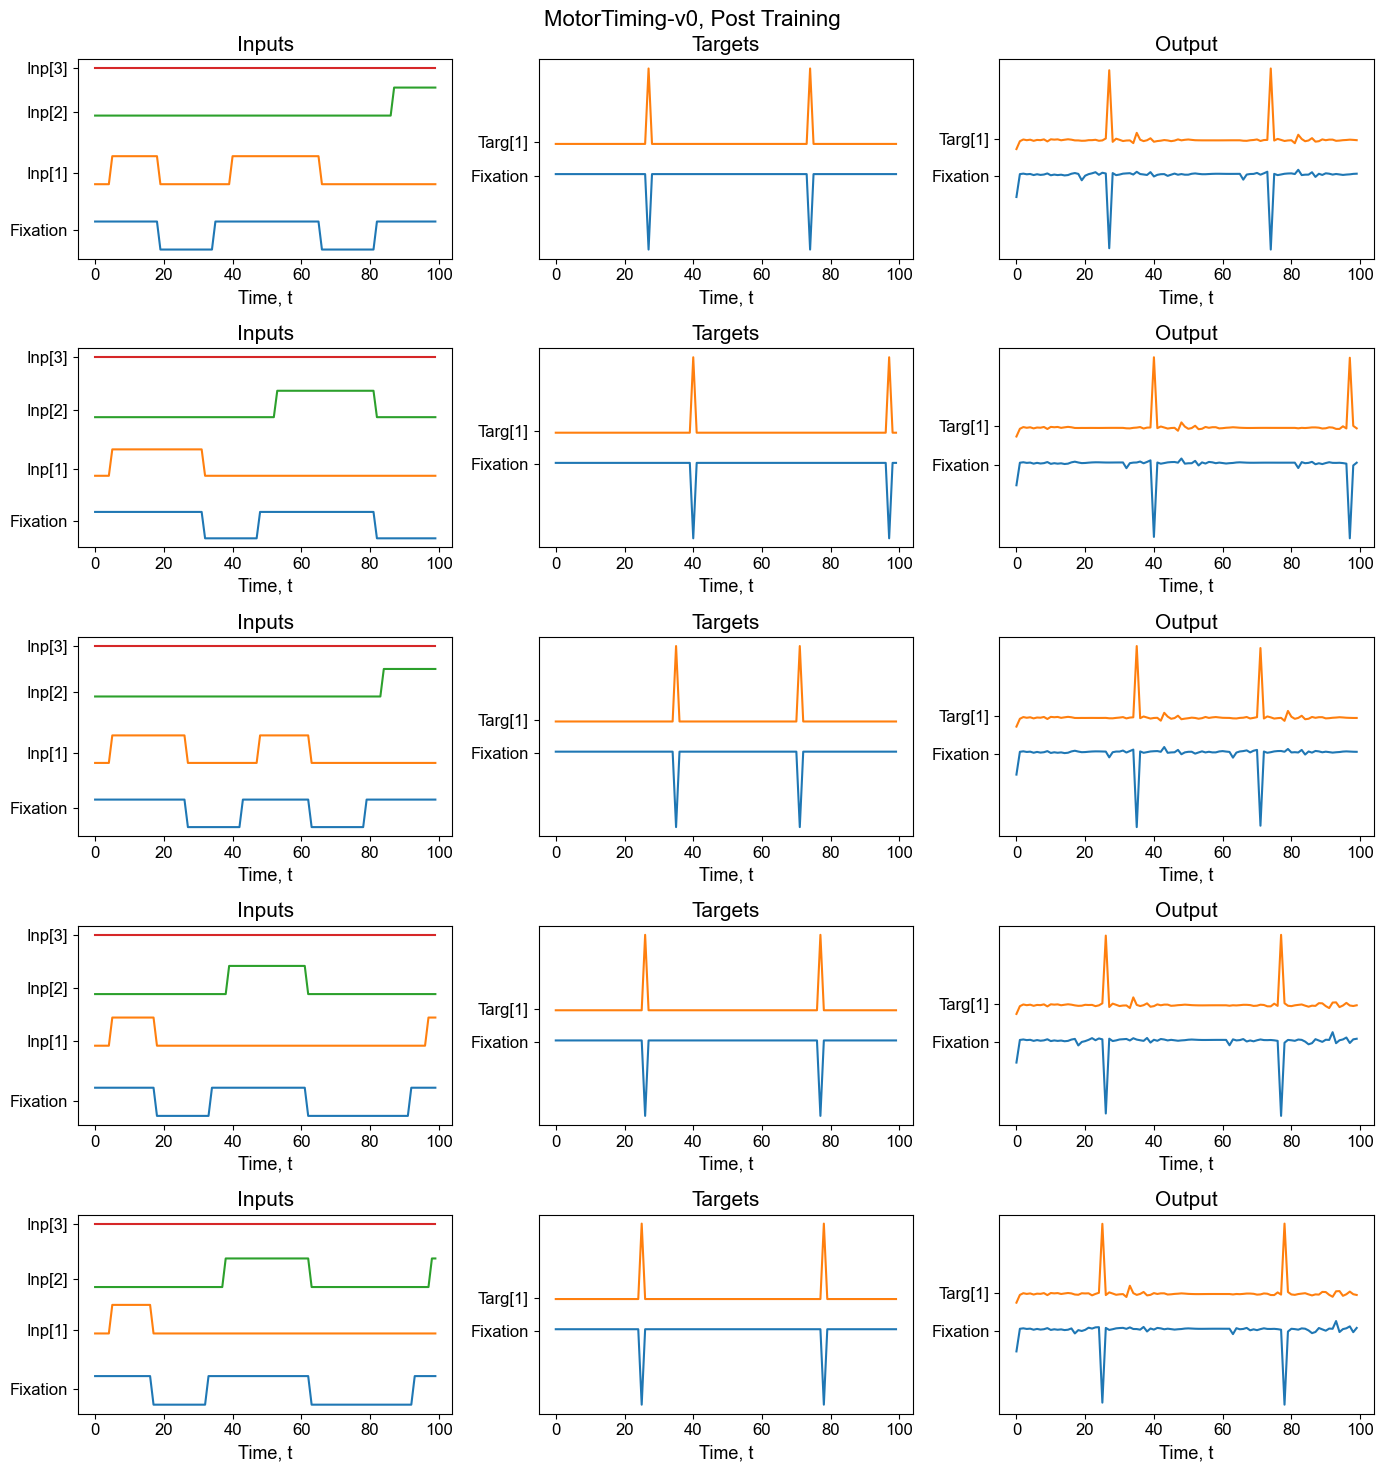

In [11]:
print("Shape of inputs, targets, labels, hidden: ", inputs.shape, targets.shape, labels.shape, zs_all.shape) # Helps me to check shapes :)


for gd_itr  in [0, -1]:
    plt.figure(figsize = (14, 3*5))
    for b in range(5):
        plt.subplot(5,3,1+3*b)
        plt.title('Inputs')
        plot_stacked(inputs[b, :, :], space = 5, ytick = ['Fixation'] + [f'Inp[{i}]' for i in range(1,inputs.shape[-1])])
        plt.subplot(5,3,2+3*b)
        plt.title('Targets')
        plot_stacked(targets[b, :, :], space = 10, ytick = ['Fixation'] + [f'Targ[{i}]' for i in range(1,targets.shape[-1])])
        plt.tight_layout()
        plt.subplot(5,3,3+3*b)
        plt.title('Output')
        plot_stacked(outs_all[gd_itr, b, :, :], space = 10, ytick = ['Fixation'] + [f'Targ[{i}]' for i in range(1,targets.shape[-1])])

    plt.suptitle(f'{task}, {"Post Training" if gd_itr == -1 else "Pre Training"}')
    plt.tight_layout()
    plt.show()

##### Plot Output Over GD:

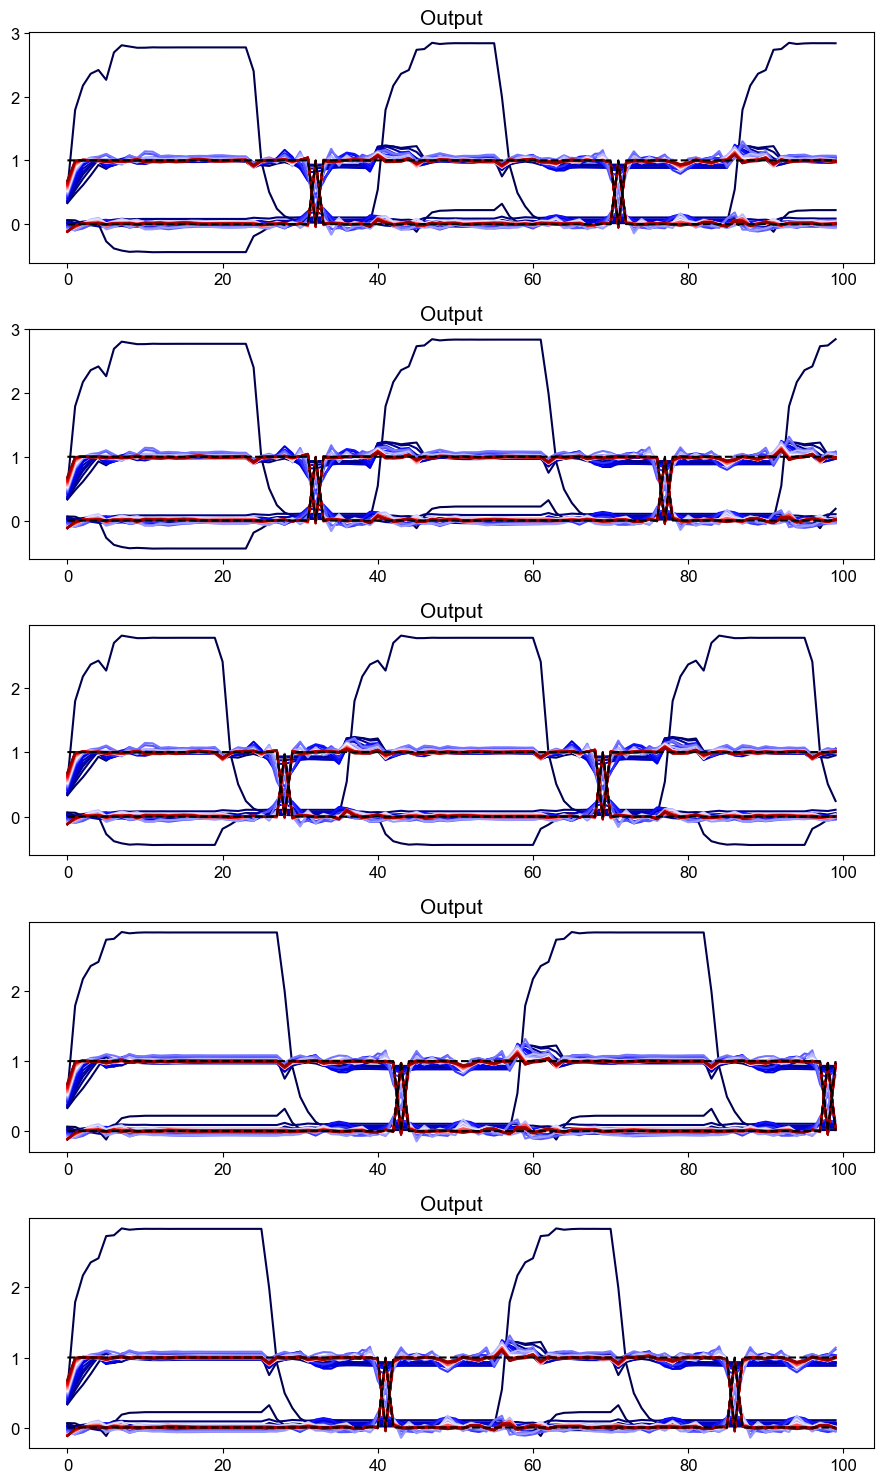

In [11]:
cmap = plt.get_cmap('seismic')
plt.figure(figsize = (9, 3*5))
ngd = outs_all.shape[0]
for b in range(5):
    for gd_itr  in range(ngd):
        plt.subplot(5,1,1+b)
        plt.title('Output')
        plt.plot(outs_all[gd_itr, b, :, :], color = cmap(gd_itr / ngd), zorder = 1)
    plt.plot(targets[b, :, :], color = 'black', linestyle = 'dashed', zorder = 10)

plt.tight_layout()
plt.show()

### Covariance Analysis for PCA: 

/home/ws3/Desktop/james/adjoint_dynamics/analysis_utils.py:119: RuntimeWarning: invalid value encountered in divide
  variance_ratios = np.cumsum(evals / total_variances[..., None], axis = -1)


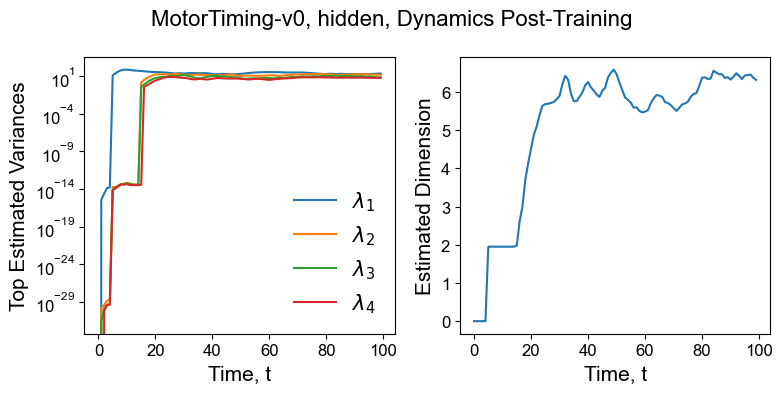

KeyboardInterrupt: 

In [12]:
# How to interpret:
# Data is shape [S, B, T, H] and we can view it in a couple ways. 
# Data[-2:-1] -> [1, B, T, H] shows post-training dynamics over trials.
# Data[:, :, -1:].swapaxes(0,2) -> [1, B, S, H] shows GD flow at final t over trials.
# Data.reshape((S, B*T, 1, H)).swapaxes(0,2) -> [1, B*T, S, H] shows GD flow over all time t and trials b. 
fn1 = lambda data: data[-2:-1]
fn2 = lambda data: data[:, :, -1:].swapaxes(0,2)
fn3 = lambda data: data.reshape((data.shape[0], -1, 1, data.shape[-1])).swapaxes(0,2)

# Helps me to think of data as a big grid:
#    ^
#  t |
#    |
#    ----->
#      s 

plot_spec = [
    {'traj': fn1(zs_all), 'title': f'{task}, hidden, Dynamics Post-Training', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': fn1(adjs_all), 'title': f'{task}, adj, Dynamics Post-Training', 'xlabel': 'Time, t', 'smoothing': 1},
    {'traj': fn3(zs_all), 'title': f'{task}, hidden, GD flow', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    {'traj': fn3(adjs_all), 'title': f'{task}, adj,  GD flow', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
    {'traj': fn3(zs_all), 'traj2': fn3(adjs_all), 'title': f'{task}, Cov(a, z) covariance,  GD flow', 'xlabel': 'GD Iteration, s', 'smoothing': 1},
]

def smooth(y, box_pts, mode = 'same'):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_dimensions(spec):
    traj, title, xlabel, smoothing = spec['traj'], spec['title'], spec['xlabel'], spec['smoothing']
    traj2 = spec.get('traj2', None)
    covs, evals, pcs, variance_ratios, dims = batched_cov_and_pcs(traj, traj2)

    plt.figure(figsize = (8, 4))
    plt.subplot(1,2,1)
    for ev_idx in range(min(evals.shape[2], 4)):
        plt.plot(evals[0, :, ev_idx], label  = f'$\\lambda_{ev_idx+1}$')
    plt.ylabel('Top Estimated Variances', fontsize = 15)
    plt.yscale('log')
    plt.xlabel(xlabel, fontsize = 15)
    plt.legend(frameon=False, fontsize = 15)

    plt.subplot(1,2,2)
    plt.xlabel(xlabel, fontsize = 15) 
    plt.ylabel('Estimated Dimension', fontsize = 15)
    if smoothing > 1:
        plt.plot(smooth(dims[0], smoothing, mode = 'valid'))
    else:
        plt.plot(dims[0])
    if 'GD' in xlabel:
        set_x_axis_iterations()
    plt.suptitle(title, fontsize = 16)
    plt.tight_layout()
    plt.show()

for spec in plot_spec:
    plot_dimensions(spec)

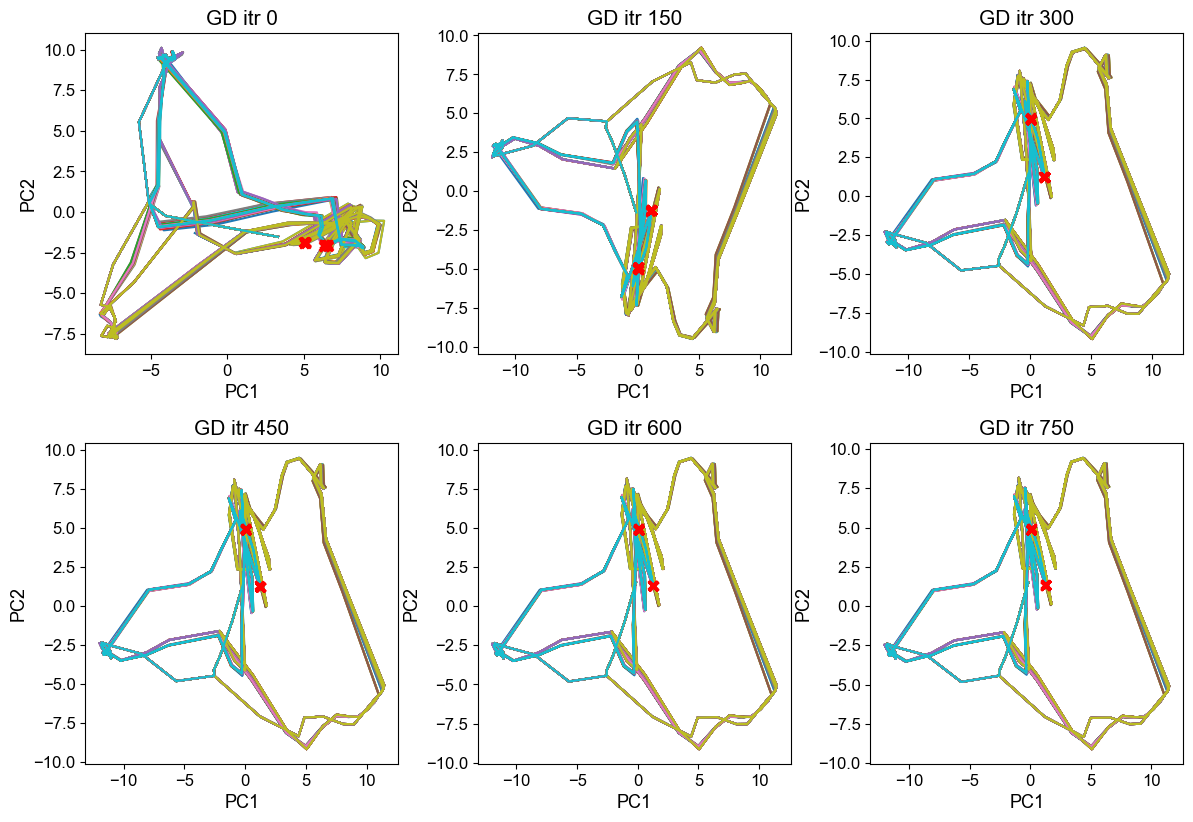

In [73]:
from sklearn.decomposition import PCA

nplot = 100
plt.figure(figsize = (12, 12))
for itr in range(0, zs_all.shape[0]-3, 3):
    ax = plt.subplot(3,3,itr//3+1)
    proj = PCA(3).fit_transform(fn3(zs_all)[0, :, itr]).reshape((zs_all.shape[1], zs_all.shape[2], -1)) # [B, T, 3]
    ax.plot(proj[:nplot, :, 0].T, proj[:nplot, :, 1].T)
    for b in range(nplot):
        response_times = np.argwhere(np.argmax(targets[b, :], axis = 1) != 0)[:, 0]
        ax.scatter(proj[b, response_times, 0], proj[b, response_times, 1], c = 'red', zorder = 10, marker = 'x')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'GD itr {GD_iteration[itr]}')
plt.tight_layout()
plt.show()

### Analysis of GD Changes

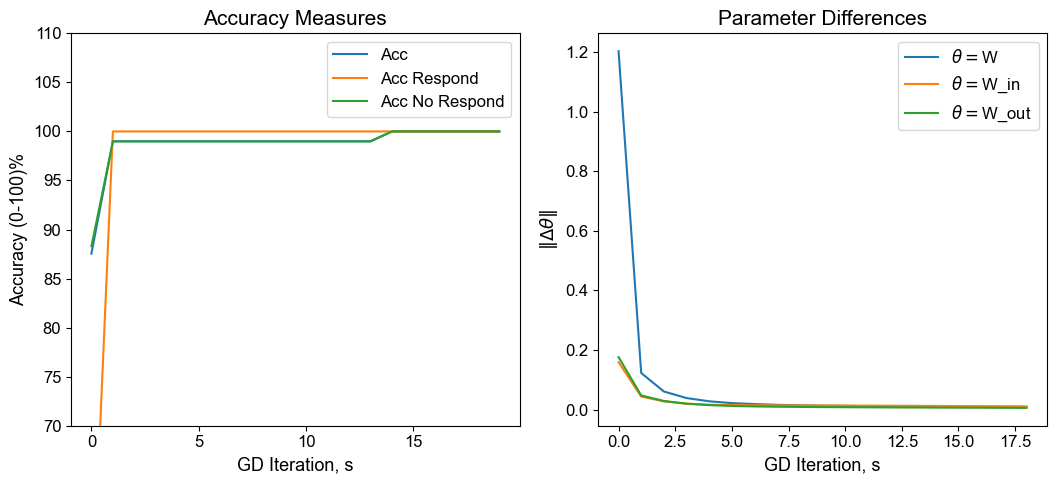

In [74]:
models = [torch.load(ch, map_location = 'cpu', weights_only = True)['model'] for ch in checkpoints]

def extract(key):
    return np.array([model[f'{key}.weight'].detach().numpy() for model in models])

param_gd_flow = {'W':extract('W'), 'W_in':extract('W_in'), 'W_out':extract('W_out')}

plt.figure(figsize = (16, 5))
plt.subplot(1,3,1)
# plt.yscale('log')
plt.plot(accs*100)
plt.ylim(70, 110)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.legend(['Acc', 'Acc Respond', 'Acc No Respond'])
plt.ylabel('Accuracy (0-100)%')
plt.xlabel('GD Iteration, s')
plt.title('Accuracy Measures')

plt.subplot(1,3,2)
for key,val in param_gd_flow.items():
    norm_gd_flow = np.linalg.norm(val[1:] - val[:-1], axis = (1, 2))
    plt.plot(norm_gd_flow, label = f'$\\theta = ${key}')
plt.legend()
# plt.yscale('log')
plt.title('Parameter Differences')
plt.xlabel('GD Iteration, s')
plt.ylabel('$\\|\\Delta \\theta\\|$')
plt.tight_layout()
plt.show()

# Scale Analysis:

### Next, look at scale of init. How does hidden dimension evolve based on input dimension. How does scale affect this?

In [21]:
def get_scaled_models(model0, gs, just_scale_W = False):
    import copy
    sweep_models = [copy.deepcopy(model0) for i in range(len(gs))]
    for g, scaled_model in zip(gs, sweep_models):
        scaled_model['W.weight'] *= g
        if not just_scale_W:
            scaled_model['W_in.weight'] *= g
            scaled_model['W_out.weight'] *= g
            scaled_model['W_out.bias'] *= g
    return sweep_models # List of state dicts

Re-evaluating on the Same Data.


100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


<h4>zs scale sweep shape is [checkpoints, trials, timesteps, n_hidden]: (3, 2000, 100, 128)</h4>

/home/ws3/Desktop/james/adjoint_dynamics/analysis_utils.py:99: RuntimeWarning: invalid value encountered in divide
  variance_ratios = np.cumsum(evals / total_variances[..., None], axis = -1)


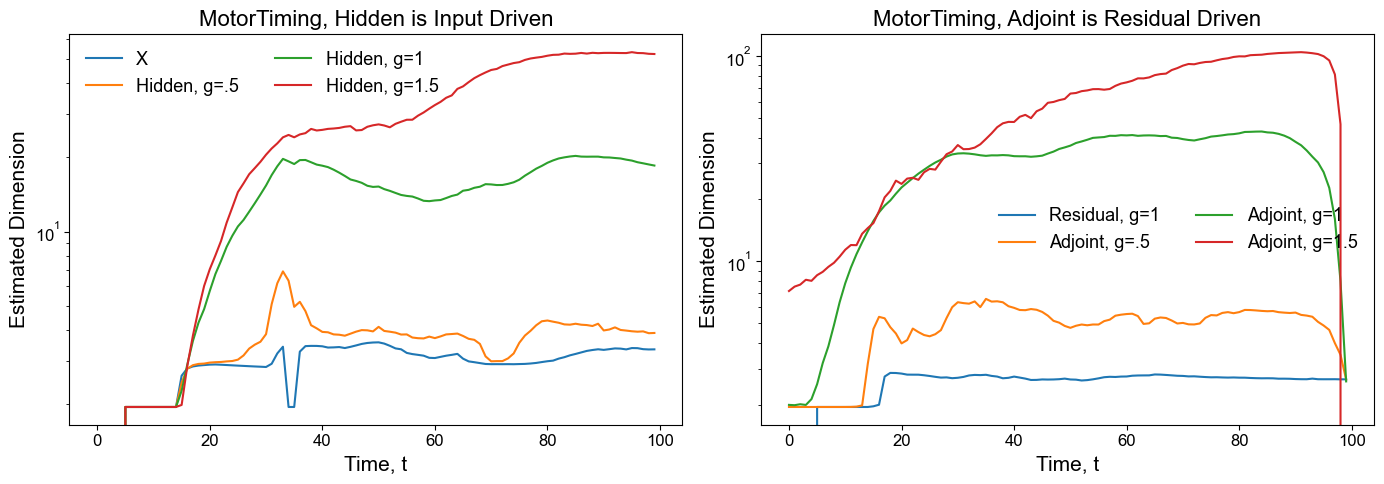

In [14]:
sweep_models = get_scaled_models(models[0], [.5, 1., 1.5], just_scale_W = True)
zs_scales, adjs_scales, outs_scales, losses_scales = rerun_trials(inputs, targets, sweep_models, compute_adj = True, device='cpu')
adjs_scales_nm = adjs_scales / np.mean(np.abs(adjs_scales))
printmd(f'zs scale sweep shape is [checkpoints, trials, timesteps, n_hidden]: {zs_scales.shape}')

residuals_scales = outs_scales - targets[None] # This will drive adjoint for MSE loss. For other losses, different story.

zs_scales = [inputs] + list(zs_scales) # To list, concatenate inputs also. 
spec1 = {'traj': zs_scales, 'title': f'{task[:-3]}, Hidden is Input Driven', 'xlabel': 'Time, t', 'smoothing': 1}
adjs_scales_nm = [residuals_scales[1]] + list(adjs_scales_nm)
spec2 = {'traj': adjs_scales_nm, 'title': f'{task[:-3]}, Adjoint is Residual Driven', 'xlabel': 'Time, t', 'smoothing': 1}

def plot_dimensions_sweep(spec):
    traj_all, title, xlabel, smoothing = spec['traj'], spec['title'], spec['xlabel'], spec['smoothing']        
    for i in range(len(traj_all)):
        traj = traj_all[i][None]
        traj2 = None if 'traj2' not in spec else spec['traj2'][i][None]
    
        dims = batched_cov_and_pcs(traj, traj2)[-1]
        dim_smooth = smooth(dims[0], smoothing, mode = 'valid')
        plt.plot(dim_smooth)

    plt.xlabel(xlabel, fontsize = 15) 
    plt.ylabel('Estimated Dimension', fontsize = 15)
    plt.title(title, fontsize = 16)
    plt.tight_layout()

plt.figure(figsize = (14, 5))
plt.subplot(1,2,1)
plot_dimensions_sweep(spec1)
plt.legend(['X', 'Hidden, g=.5', 'Hidden, g=1', 'Hidden, g=1.5'], ncol=2, frameon=False, fontsize = 13)
plt.yscale('log')
# plt.tight_layout()
plt.subplot(1,2,2)
# plt.savefig('Dimension_scale.pdf')
# plt.figure(figsize = (10, 5))
plot_dimensions_sweep(spec2)
plt.legend(['Residual, g=1', 'Adjoint, g=.5', 'Adjoint, g=1', 'Adjoint, g=1.5'], ncol=2, frameon=False, fontsize = 13)
plt.yscale('log')
plt.tight_layout()
plt.savefig('Dimension_scale_all.pdf')
plt.show()

## Geometric Implications Section

#### Let's look at the gradient changes and compare them to Theorem 2 in the main paper:

In [14]:
grads_W = [grads['W.weight'] for grads in grads_all]
sig_all = np.tanh(zs_all)

In [15]:
# Sum up outer products a[t+1] * sigma(z[t])^T. 
outer = np.sum(adjs_all[-3, :, 1:, :, None] * sig_all[-3, :, :-1, None, :], (0,1))
print(outer.shape)

(128, 128)


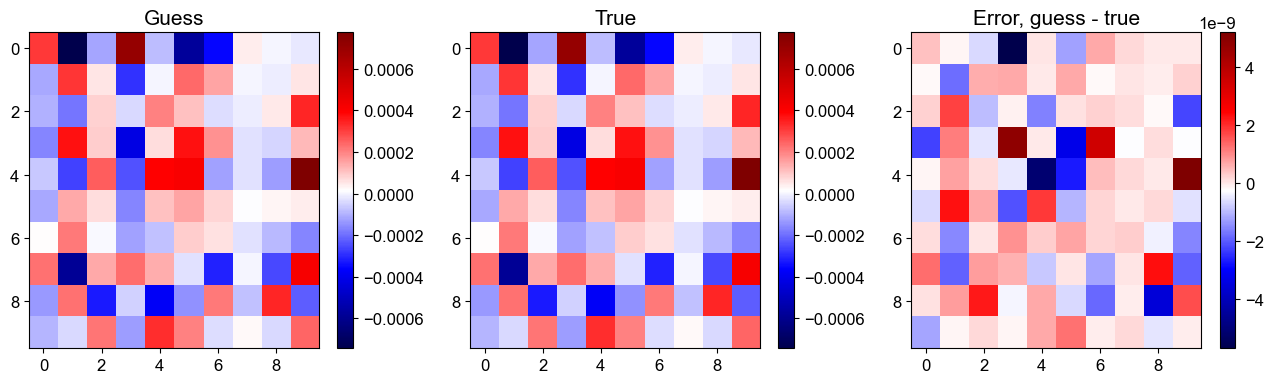

In [166]:
def compare_2d(guess, true, **kwargs):
    plt.figure(figsize = (13, 4))
    plt.subplot(1,3,1)
    plt.imshow(guess, cmap = 'seismic', aspect = 'auto', **kwargs)
    plt.title('Guess')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(true, cmap = 'seismic', aspect = 'auto', **kwargs)
    plt.title('True')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(guess - true, cmap = 'seismic', aspect = 'auto', **kwargs)
    plt.title('Error, guess - true')
    plt.colorbar()
    plt.tight_layout()

compare_2d(outer[:10, :10], grads_W[-3][:10, :10])
plt.show()

In [19]:
print(adjs_all.shape, adjs_all[-3].reshape(-1, adjs_all.shape[-1]).shape)
prepro = adjs_all[-3,:,1:].reshape(-1, adjs_all.shape[-1])
prepro2 = sig_all[-3,:,:-1].reshape(-1, zs_all.shape[-1])
print(prepro.shape)
# cross_covs_2 = batched_cov_and_pcs(prepro, prepro2)[0][0,0]

mu, mu2 = prepro.mean(0), prepro2.mean(0)
cross_covs_2 = ((prepro - mu[None])[:, :, None] * (prepro2 - mu2[None])[:, None, :]).mean(0)
print(cross_covs_2.shape)

mean_term = np.outer(mu, mu2)
print(mean_term.shape)

(30, 1000, 100, 128) (100000, 128)
(99000, 128)
(128, 128)
(128, 128)


In [153]:
reduce = zs_all.shape[1] * (zs_all.shape[2] - 1) * (cross_covs_2 + mean_term)

print(sig_all.shape)
mean_sig_all = sig_all.mean(axis = (1,2))[-3]
mean_adjs_all = adjs_all.mean(axis = (1,2))[-3]
print(mean_sig_all.shape)
outer_mean = mean_adjs_all[:, None] * mean_sig_all[None, :]
# guess = cross_covs

compare_2d(reduce[:10, :10], grads_W[-3][:10, :10])
plt.show()

ValueError: operands could not be broadcast together with shapes (128,128) (128,4) 

In [70]:
changes_guess, changes_mean_term, changes_cross = [], [], []
for b in range(adjs_all.shape[0]):
    prepro = adjs_all[b,:,1:].reshape(-1, adjs_all.shape[-1])
    prepro2 = sig_all[b,:,:-1].reshape(-1, sig_all.shape[-1])
    mu, mu2 = prepro.mean(0), prepro2.mean(0)
    cross = ((prepro - mu[None])[:, :, None] * (prepro2 - mu2[None])[:, None, :]).mean(0)
    mean_term = np.outer(mu, mu2)
    changes_guess.append(cross + mean_term)
    changes_cross.append(cross)
    changes_mean_term.append(mean_term)
changes_guess, changes_mean_term, changes_cross = np.stack(changes_guess), np.stack(changes_mean_term), np.stack(changes_cross)

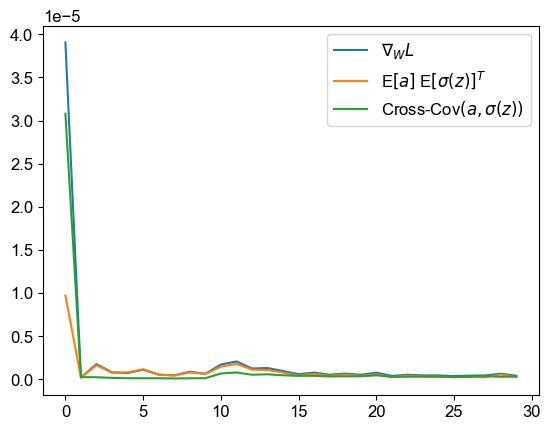

In [72]:
get_norm = lambda vec_of_mats: np.stack([np.linalg.norm(A) for A in vec_of_mats])
plt.plot(get_norm(changes_guess))
plt.plot(get_norm(changes_mean_term))
plt.plot(get_norm(changes_cross))
plt.legend(['$\\nabla_W L$', 'E$[a]$ E$[\\sigma(z)]^T$', 'Cross-Cov$(a, \\sigma(z))$'])
# plt.yscale('log')
plt.show()

In [116]:
inputs_centered = inputs - inputs.mean((0,1), keepdims = True)

In [117]:
mean_terms_inp, crosses_inp = [], []
for b in range(adjs_all.shape[0]):
    prepro = adjs_all[b,:,1:].reshape(-1, adjs_all.shape[-1])
    prepro2 = inputs_centered[:,:-1].reshape(-1, inputs.shape[-1])
    mu, mu2 = prepro.mean(0), prepro2.mean(0)
    cross = ((prepro - mu[None])[:, :, None] * (prepro2 - mu2[None])[:, None, :]).mean(0)
    mean_term = np.outer(mu, mu2)
    mean_terms_inp.append(mean_term)
    crosses_inp.append(cross)
mean_terms_inp, crosses_inp = np.stack(mean_terms_inp), np.stack(crosses_inp)

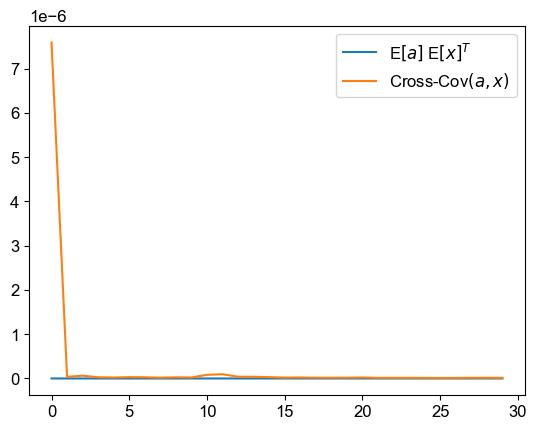

In [118]:
get_norm = lambda vec_of_mats: np.stack([np.linalg.norm(A) for A in vec_of_mats])
plt.plot(get_norm(mean_terms_inp))
plt.plot(get_norm(crosses_inp))
plt.legend(['E$[a]$ E$[x]^T$', 'Cross-Cov$(a, x)$'])
plt.show()

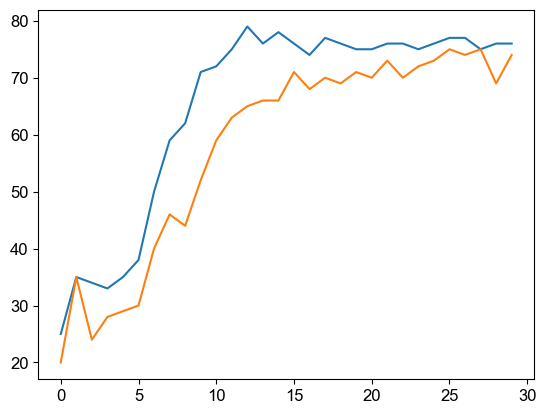

In [91]:
get_rank = lambda vec_of_mats: np.stack([np.linalg.matrix_rank(A) for A in vec_of_mats])
select = lambda key: [grad[f'{key}.weight'] for grad in grads_all]
plt.plot(get_rank(changes_cross))
plt.plot(get_rank(select('W')))
plt.show()

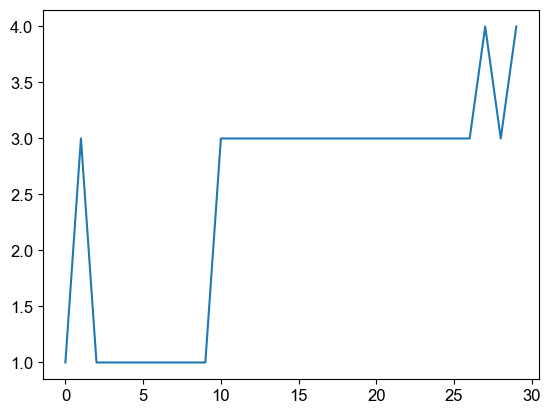

In [90]:
get_rank_eff = lambda vec_of_mats, thresh: np.stack([effective_rank(A, thresh) for A in vec_of_mats])
plt.plot(get_rank_eff(changes_guess, .97))
# plt.plot(get_rank_eff(select('W'), 1.0 - 1e-5))
plt.show()

### Approximate dZ/ds Using a Centered Difference Formula and Analyze it

In [102]:
import copy
models_step_back, models_step_forw = [], []
ds = 0.1 # How much to move along GD direction. Should be small. Found rule of thumb sqrt(machine eps) * |s|.
for gd_idx, ch in enumerate(checkpoints):
    model = import_checkpoint(ch)['model']
    models_step_back.append({key: val - ds * grads_all[gd_idx][key] for key, val in model.items()})
    models_step_forw.append({key: val + ds * grads_all[gd_idx][key] for key, val in model.items()})

zs_all_back = rerun_trials(inputs, targets, models_step_back, device='cpu', verbose = True)
zs_all_forw = rerun_trials(inputs, targets, models_step_forw, device='cpu', verbose = True)

dz_ds = (zs_all_forw - zs_all_back) / (2*ds) # [S, B, T, H]
norms_dz_ds = np.mean(np.linalg.norm(dz_ds, axis=-1), (1,2))

Re-evaluating on the Same Data.


100%|██████████| 30/30 [00:01<00:00, 16.71it/s]


Re-evaluating on the Same Data.


100%|██████████| 30/30 [00:01<00:00, 15.74it/s]


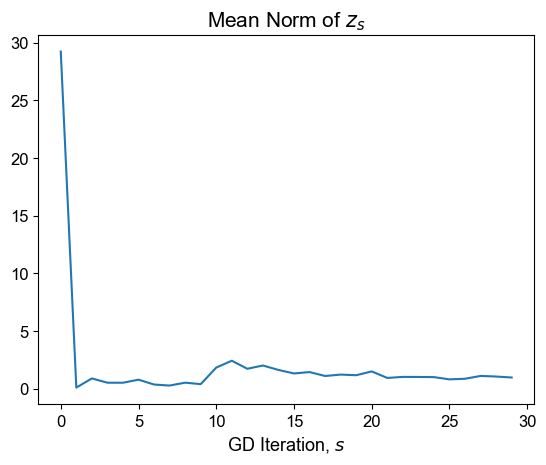

In [104]:
plt.plot(norms_dz_ds)
# plt.yscale('log')
plt.title('Mean Norm of $z_s$')
plt.xlabel('GD Iteration, $s$')
plt.show()

In [105]:
dims_dz_ds = batched_cov_and_pcs(dz_ds)[-1]

/home/ws3/Desktop/james/adjoint_dynamics/analysis_utils.py:119: RuntimeWarning: invalid value encountered in divide
  variance_ratios = np.cumsum(evals / total_variances[..., None], axis = -1)


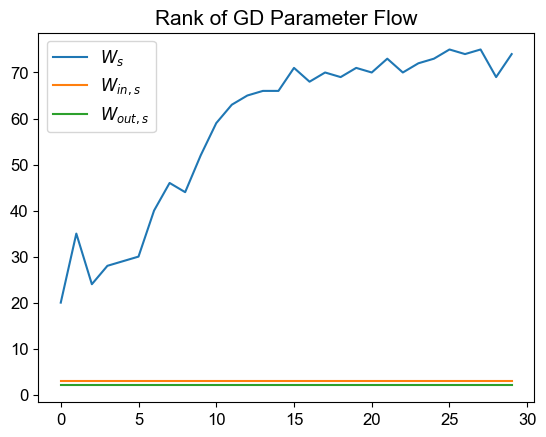

In [106]:
select = lambda key: [grad[f'{key}.weight'] for grad in grads_all]
grads_W, grads_W_in, grads_W_out = select('W'), select('W_in'), select('W_out')
plt.plot([np.linalg.matrix_rank(dW) for dW in grads_W])
plt.plot([np.linalg.matrix_rank(dW) for dW in grads_W_in])
plt.plot([np.linalg.matrix_rank(dW) for dW in grads_W_out])
plt.legend(['$W_s$', '$W_{in,s}$', '$W_{out,s}$'])
plt.title('Rank of GD Parameter Flow')
plt.show()

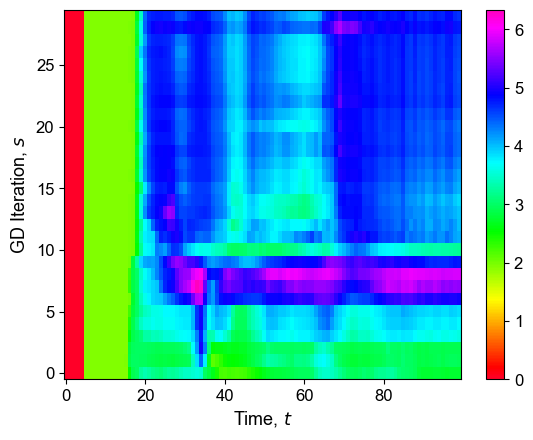

In [107]:
plt.imshow(dims_dz_ds, aspect='auto', origin = 'lower', cmap = 'gist_rainbow')
plt.xlabel('Time, $t$')
plt.ylabel('GD Iteration, $s$')
plt.colorbar()
plt.show()

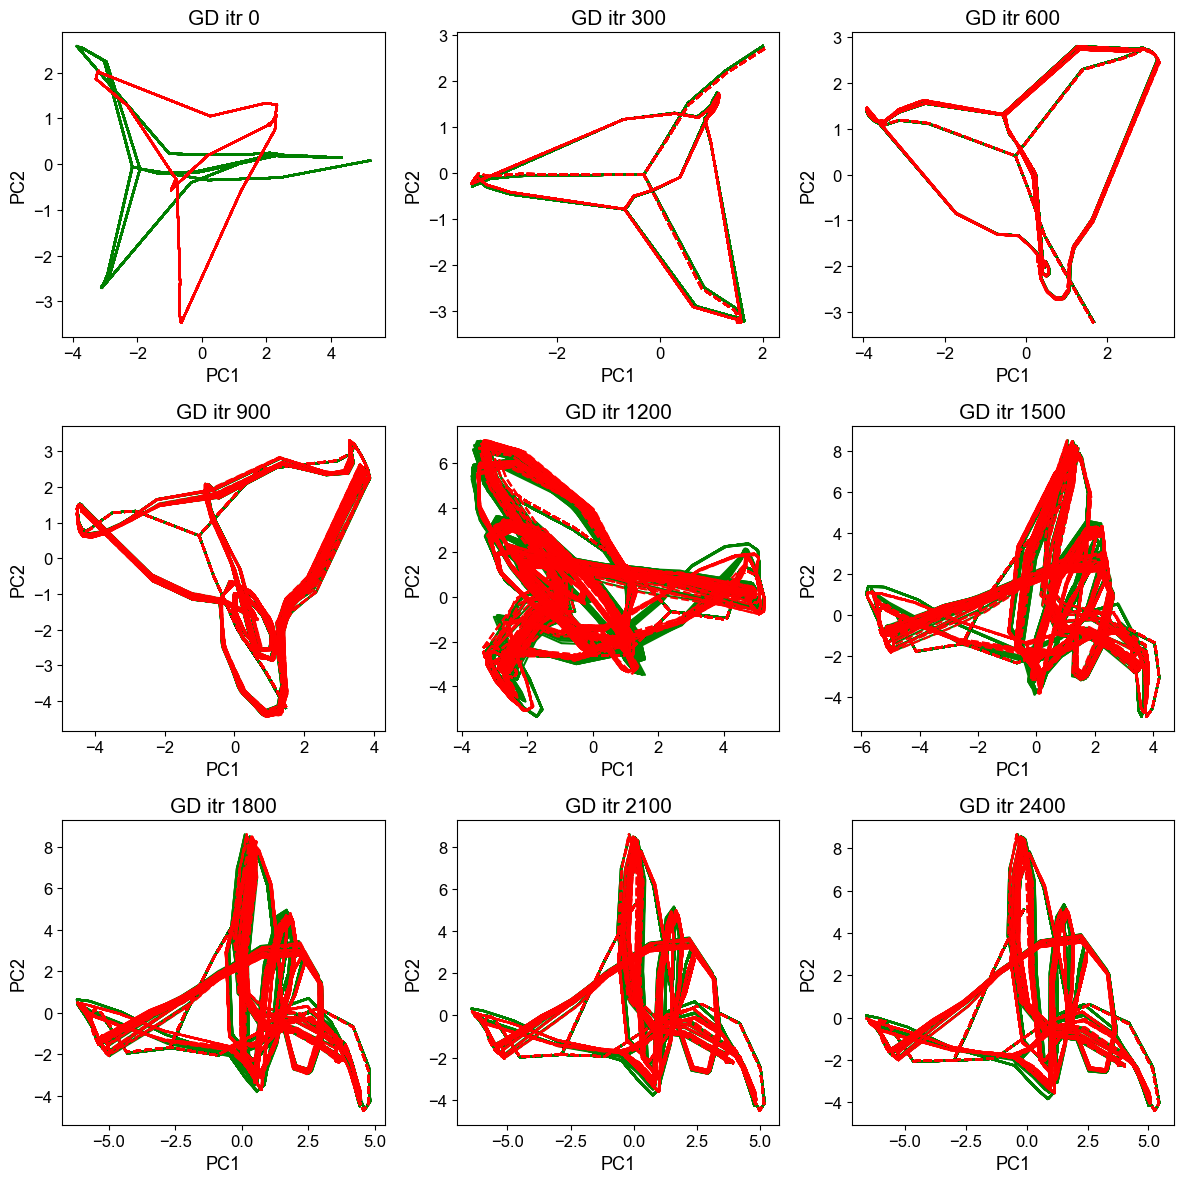

In [108]:
from sklearn.decomposition import PCA

def plot_zs_pc_space(zs_all, **kwargs):
    nplot = 100
    for itr in range(0, zs_all.shape[0]-3, 3):
        ax = plt.subplot(3,3,itr//3+1)
        proj = PCA(3).fit_transform(fn3(zs_all)[0, :, itr]).reshape((zs_all.shape[1], zs_all.shape[2], -1)) # [B, T, 3]
        ax.plot(proj[:nplot, :, 0].T, proj[:nplot, :, 1].T, **kwargs)
        # for b in range(nplot):
        #     response_times = np.argwhere(np.argmax(targets[b, :], axis = 1) != 0)[:, 0]
        #     ax.scatter(proj[b, response_times, 0], proj[b, response_times, 1], c = 'red', zorder = 10, marker = 'x')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(f'GD itr {GD_iteration[itr]}')
    plt.tight_layout()

plt.figure(figsize = (12, 12))
plot_zs_pc_space(zs_all_back, color='red', zorder=10, linestyle='dashed')
plot_zs_pc_space(zs_all_forw, color='green', zorder = 9)
plt.show()

# Speculative:

In [123]:
mu_z = np.mean(zs_all, axis = (1, 2))
mu_sig = np.mean(sig_all, axis = (1,2))
mu_x = np.mean(inputs, axis = (0,1))
mu_z.shape, mu_sig.shape, mu_x.shape

((30, 128), (30, 128), (4,))

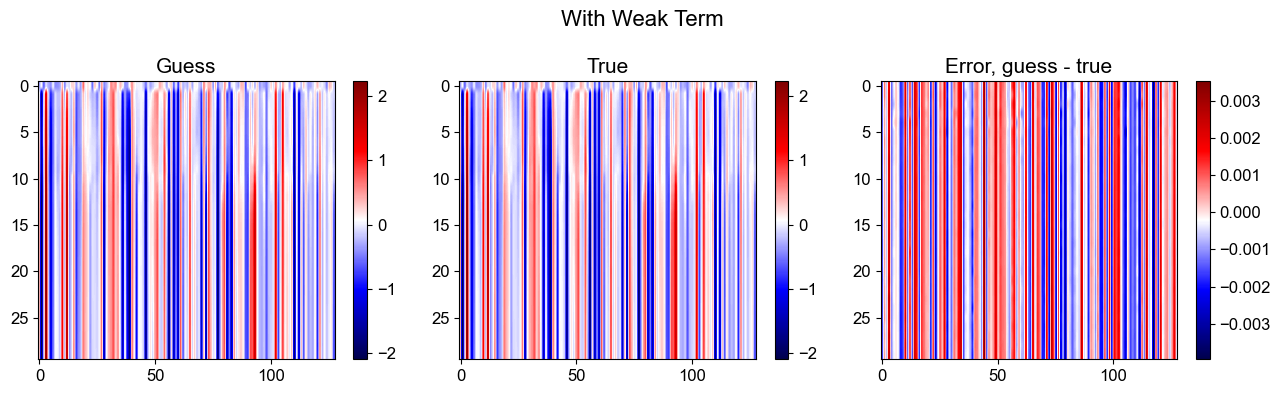

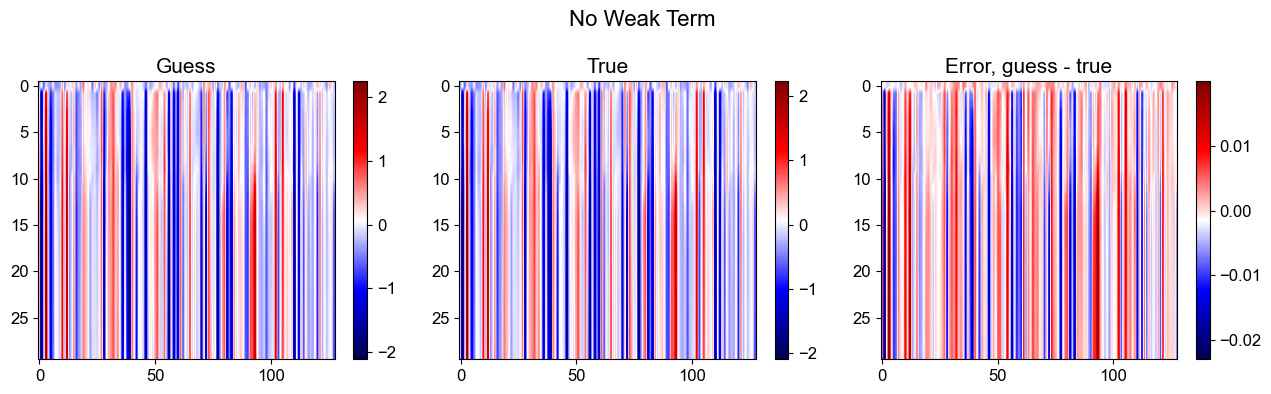

In [168]:
right_mul = lambda W, x: x @ W.detach().numpy().T 

def estimate_mean_of_z(include_weak_term = True):
    guess_mu_z = []
    for gd_idx, ch in enumerate(checkpoints):
        sd = import_checkpoint(ch)['model']
        weak_term = (zs_all[gd_idx, :, -1] - zs_all[gd_idx, :, 0]) / zs_all.shape[2]
        weak_term = np.mean(weak_term, 0) # Mean over trials
        guess_mu_z.append(right_mul(sd['W.weight'], mu_sig[gd_idx]) + right_mul(sd['W_in.weight'], mu_x)) 
        if include_weak_term:
            guess_mu_z[-1] -= weak_term
    return np.stack(guess_mu_z)

compare_2d(estimate_mean_of_z(True), mu_z)
plt.suptitle('With Weak Term')
plt.tight_layout()
plt.show()

compare_2d(estimate_mean_of_z(False), mu_z)
plt.suptitle('No Weak Term')
plt.tight_layout()
plt.show()

## Figures Sweeping Over Many Tasks:

### To be more comprehensive, measure how the mean of the ratio of hidden dimension to input dimension grows with scale. Do this for many tasks. 

#### NOTE: this code will redefine task, inputs, labels, etc. So you need to rerun ALL of the above if you want to play with that. 

In [15]:
tasks_all = ['AntiReach-v0',
# 'Bandit-v0',
'ContextDecisionMaking-v0',
# 'DawTwoStep-v0',
'DelayComparison-v0',
'DelayMatchCategory-v0',
'DelayMatchSample-v0',
'DelayMatchSampleDistractor1D-v0',
'DelayPairedAssociation-v0',
'DualDelayMatchSample-v0',
# 'EconomicDecisionMaking-v0',
'GoNogo-v0',
'HierarchicalReasoning-v0',
'IntervalDiscrimination-v0',
'MotorTiming-v0',
'MultiSensoryIntegration-v0',
'OneTwoThreeGo-v0',
'PerceptualDecisionMaking-v0',
'PerceptualDecisionMakingDelayResponse-v0',
'PostDecisionWager-v0',
'ProbabilisticReasoning-v0',
'PulseDecisionMaking-v0',
'Reaching1D-v0',
'Reaching1DWithSelfDistraction-v0',
# 'ReachingDelayResponse-v0',
'ReadySetGo-v0',
'SingleContextDecisionMaking-v0'
]
tasks_good = 'MotorTiming-v0 AntiReach-v0 DelayComparison-v0 ProbabilisticReasoning-v0 MultiSensoryIntegration-v0 PerceptualDecisionMaking-v0 PerceptualDecisionMakingDelayResponse-v0'
tasks_good = tasks_good.split()

In [16]:
from architecture import SequentialModel
gs = np.linspace(0., 2.5, 15)

ratios = []
for task in tqdm(tasks_good):
    inputs, labels, targets = load_task(task, ntrials = 2560)
    model0 = SequentialModel(n_hidden = 128, n_in = inputs.shape[-1], n_out = targets.shape[-1]).state_dict()

    checkpoints, GD_iteration = load_checkpoints(neurogym_root + 'run2_' + task + '/')
    model0 = torch.load(checkpoints[-1], weights_only=True, map_location='cpu')['model']

    sweep_models = get_scaled_models(model0, gs, just_scale_W = True)
    zs_scales = rerun_trials(inputs, targets, sweep_models, device='cpu', verbose = False)

    input_dim = batched_cov_and_pcs(inputs[None])[-1][0] # [tsteps]
    hidden_dims = batched_cov_and_pcs(zs_scales)[-1] # [len(gs), tsteps]
    rat = np.mean(hidden_dims,1) / np.mean(input_dim)
    ratios.append(rat)
ratios = np.stack(ratios)

  0%|          | 0/7 [00:00<?, ?it/s]/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/home/ws3/anaconda3/envs/james/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
 

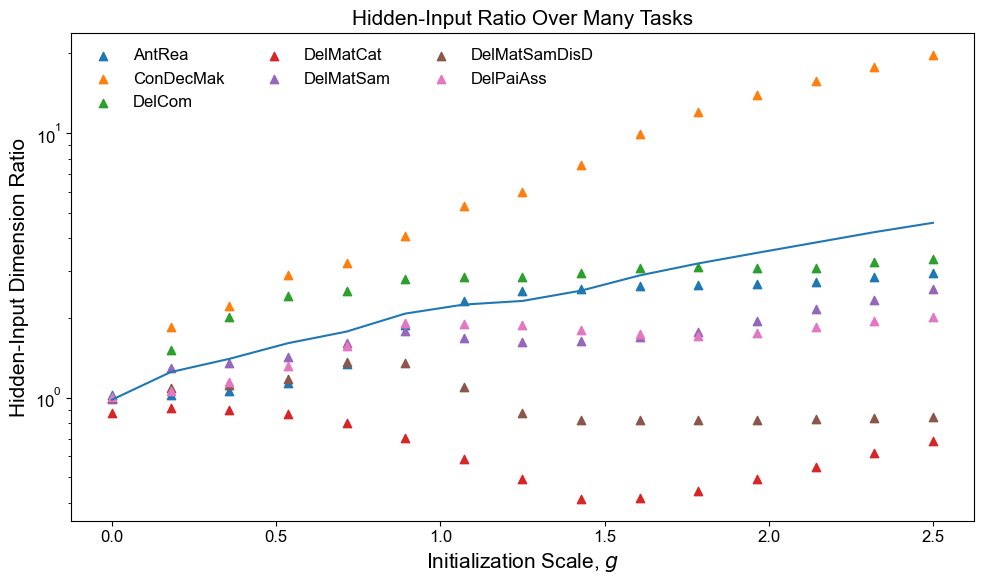

In [17]:

def condense_name(name):
    name = name[:-3] # Cut out -v0
    lower = lambda s: ''.join([s[0]] + [c for c in s[1:] if c.islower()])
    name = ''.join(lower(name[i:i+3]) for i, c in enumerate(name) if c.isupper())
    return name

plt.figure(figsize = (10, 6))
mask = ~np.isnan(ratios).any(axis=1)
ratios_clean = ratios[mask]


abbr_task_names = [condense_name(name) for name in tasks_all]
for idx, (rat, task_name) in enumerate(zip(ratios, abbr_task_names)):
    marker = '*' if idx >= 20 else ('x' if idx >= 10 else '^') # 10 distinct colors, so use different marker for every 10
    plt.scatter(gs, rat, label=task_name, marker = marker)


plt.legend(frameon=False, ncol=3, fontsize = 12)
plt.plot(gs, ratios_clean.mean(0))
plt.yscale('log')
plt.xlabel('Initialization Scale, $g$', fontsize = 15)
plt.ylabel('Hidden-Input Dimension Ratio', fontsize = 15)
plt.title('Hidden-Input Ratio Over Many Tasks')
plt.tight_layout()
plt.savefig('Dimension_ratios_tasks_post_training.pdf')
plt.show()

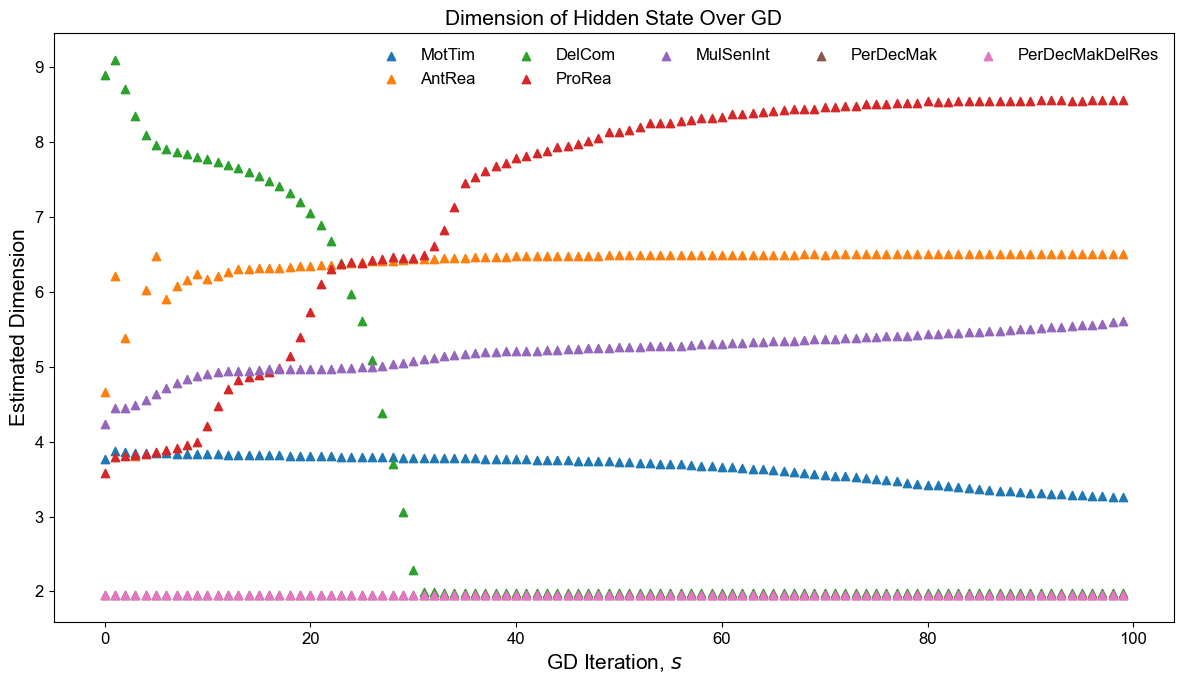

In [18]:
# Todo: put dim code here
dims_all = np.loadtxt('dims_all.csv')

plt.figure(figsize = (12, 7))

abbr_task_names = [condense_name(name) for name in tasks_decent_acc]
for idx, (dims, task_name) in enumerate(zip(dims_all, abbr_task_names)):
    marker = '*' if idx >= 20 else ('x' if idx >= 10 else '^') # 10 distinct colors, so use different marker for every 10
    plt.scatter(np.arange(len(dims)), dims, label=task_name, marker = marker)

plt.legend(frameon=False, ncol=5, fontsize = 12)
# plt.plot(dims_all.mean(0))
# plt.yscale('log')
plt.xlabel('GD Iteration, $s$', fontsize = 15)
plt.ylabel('Estimated Dimension', fontsize = 15)
plt.title('Dimension of Hidden State Over GD')
plt.tight_layout()
plt.savefig('Dimension_all_tasks.pdf')
plt.show()
